# Data visualisation
$\textbf{by Prakash Srinivsan, Ryan van der Werf and Jim van Veenhuyzen (group 70)}$

## Introduction
In this notebook we aim to visualise our data obtained from the matrix factorization algorithms in the other notebook. More specifically, we use the feature matrices for both the users and movies. The user and movie matrices are $U$ and $V$ & $U$ and $M$ for the $\textbf{UV decomposition}$ and the $\textbf{Matrix Factorization}$ respectively. 

## Approach
Our approach for the data visualition will be first to apply the dimensionality reduction techniques on one of each of the feature matrices we obtained from the matrix factorization algorithms, so for a user matrix $\textbf{U}$ and a movie matrix $\textbf{M}$. From this, we will 

In [2]:
#Import general python libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random
#Import sklearn related functions, most importantly PCA and TSNE
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#Import UMAP 
import umap
import umap.plot

In [3]:
#First read in the MovieLens 1M data

usersData = pd.read_csv('users.dat', sep='::', header=None, \
                        names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')
ratingsData = pd.read_csv('ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
moviesData = pd.read_csv('movies.dat', sep='::', header=None, \
                         names=['MovieID', 'Title', 'Genres'], engine='python', encoding='latin1')

Lets first inspect how the user and movie data looks so we can identify which features belong to the users and movies.

In [4]:
usersData.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


We can see that the relevant features for the users are the user's $\textit{gender}$, $\textit{age}$ and $\textit{occupation}$. 

In [5]:
moviesData.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


We can see that the relevant features for the movies are the movie's $\textit{title}$ and $\textit{genres}$, but from the $\textit{title}$ the $\textit{year}$ of release is the most interesting to look at, and the $\textit{genre}$ features encompasses various genres. Next, we load in the feature matrices generated from the UV-decomposition and Matrix Factorization algorithms. For both the UV-decomposition and the matrix decomposition algorithms, we applied 5-fold cross validation, which means we have 5 user-feature matrices $U$ and 5 movie-feature matrices $V$ respectively for both methods. As it is inconvenient to use all 20 of these matrices for the visualisation, we instead pick just one of the $U$ and $V$ matrices for each method. The difference in RMSE values between folds is tiny, so we decide to use the matrices from the first fold, but again which one is used seems trivial. Next to the matrices, we also import a list of user and movie IDs from the training sets used. This is because if we split the total data into smaller parts, there is no guarantee that we retain all different users and movies: it can occur that we do not include any of the ratings given by some user $i$ or any of the ratings given for some movie $j$.  

In [21]:
#Import the feature matrices obtained from the UV-decomposition algorithm using d=2 (1st fold)
U_uvdecomp = np.load('U_matrix_fold1.npy')
V_uvdecomp = np.load('V_matrix_fold1.npy')
users = np.load('userID_fold1.npy') 
movies = np.load('movieID_fold1.npy')

In [46]:
#Import the feature matrices obtained from the Matrix Factorization algorithm using num_factors=10 (1st fold)
U_matrixfac = np.load('predicted_U_1.npy')
V_matrixfac = np.load('predicted_M_1.npy')

Lets view the header of one of the feature matrices we generated, for example the U-matrix generated by 
the Matrix Decomposition algorithm using num_factors=10. This means there are 10 user-features for each user.

In [40]:
print('The size of the U-matrix is:',U_matrixfac.shape)

user_features = np.arange(1,11,1) #num_factors=10 was used, so there are 10 user-features
df_U_matrixfac = pd.DataFrame(data=U_matrixfac,index=users, columns=user_features)
df_U_matrixfac.head()

The size of the U-matrix is: (6036, 10)


,1,2,3,4,5,6,7,8,9,10
1,0.860823,0.190604,0.268035,0.863651,0.632721,0.535228,0.208387,0.725279,0.646824,0.905409
2,0.233199,0.442093,0.271232,0.844727,0.882524,-0.100023,0.714339,0.921956,-0.002386,0.898872
3,1.061206,0.912620,1.189597,0.871939,0.345037,-0.297734,0.507672,0.840903,-0.154345,0.412239
4,1.311179,0.589009,0.383098,0.140379,0.262039,0.787067,0.357429,0.969267,0.575986,0.769088
5,0.017798,0.368527,0.424269,0.093695,0.729064,1.347575,0.553867,0.083483,0.639838,-0.148672


Interestingly we are missing a tiny number of users, as the total amount of user IDs is 6040. This is a general trend for all feature matrices, which also means this applies to the movie feature matrices also. Therefore, we apply a mask using the userID and movieID data we saved during the matrix factorization algorithms, so that we can match which users and movies are present in our feature matrices. 

Now that we've imported the data, lets apply the dimensionality reduction techniques to reduce the dimensionality to 2. We decide to use $\textbf{PCA}$ and $\textbf{UMAP}$ here, as the visual difference between $\textbf{t-SNE}$ and $\textbf{UMAP}$ is minimal in this case. First, we analyse the user matrix $U$ from the $\textbf{Matrix Factorization}$. For the user data, the main areas of interest are the $\textit{gender}$, $\textit{age}$ and $\textit{occupation}$ of the user. The following code inspects whether there is any clustering for the $\textit{genders}$ and $\textit{ages}$ of the users. 

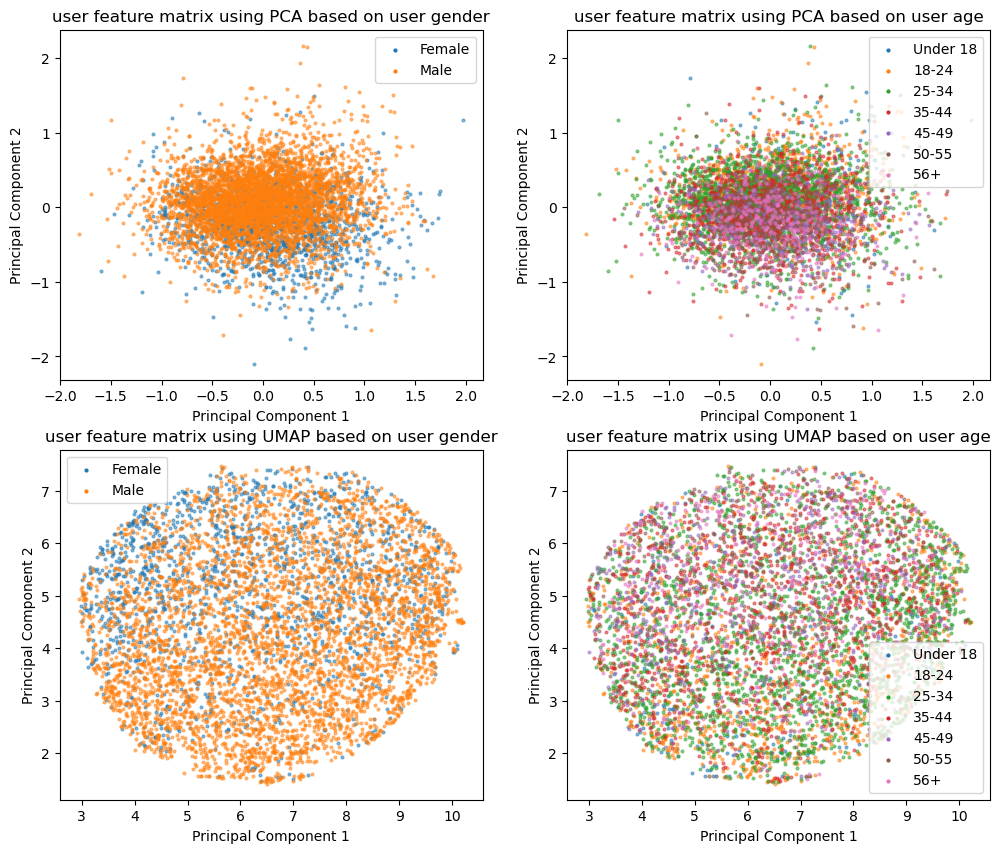

In [47]:
#Obtain the user data in the Gender and Age columns
U_matrixfac_user = usersData[usersData['UserID'].isin(users1)]

#Define the genders and corresponding labels
U_matrixfac_gender = U_matrixfac_user['Gender']
labels_gender = ['Female','Male']

#Define the ages and corresponding labels
U_matrixfac_age = U_matrixfac_user['Age']
labels_age = ["Under 18","18-24","25-34","35-44","45-49","50-55","56+"]

#Apply the PCA on the U-matrix, reducing the number of user-features and thus the amount of columns to 2
pca = PCA(n_components=2)
pca_data_U_matrixfac = pca.fit_transform(U_matrixfac)

#Apply UMAP on the U-matrix
umap_U_matrixfac = umap.UMAP(n_components=2)
umap_data_U_matrixfac = umap_U1.fit_transform(U_matrixfac)

#Visualise the clustering based on gender
fig, ax = plt.subplots(2,2,figsize=(12,10))
label_index = 0
s = 0
for i in np.unique(U_matrixfac_gender):
    indices = np.where(U_matrixfac_gender == i)
    ax[0,0].scatter(pca_data_U_matrixfac[:,0][indices], pca_data_U_matrixfac[:,1][indices],\
                    s=4,alpha=0.5,label=labels_gender[label_index])
    label_index += 1
    
leg = ax[0,0].legend()
for lh in leg.legend_handles: 
    lh.set_alpha(1)
ax[0,0].set_title('user feature matrix using PCA based on user gender')
ax[0,0].set_xlabel('Principal Component 1')
ax[0,0].set_ylabel('Principal Component 2')

#Visualise the clustering based on ages
label_index = 0 
for i in np.unique(U_matrixfac_age):
    indices = np.where(U_matrixfac_age == i)
    ax[0,1].scatter(pca_data_U_matrixfac[:,0][indices], pca_data_U_matrixfac[:,1][indices],\
                    s=4,alpha=0.5,label=labels_age[label_index])
    label_index += 1
leg = ax[0,1].legend()
for lh in leg.legend_handles: 
    lh.set_alpha(1)
ax[0,1].set_title('user feature matrix using PCA based on user age')
ax[0,1].set_xlabel('Principal Component 1')
ax[0,1].set_ylabel('Principal Component 2')

#Visualise the clustering based on gender
label_index = 0
for i in np.unique(U_matrixfac_gender):
    indices = np.where(U_matrixfac_gender == i)
    ax[1,0].scatter(umap_data_U_matrixfac[:,0][indices], umap_data_U_matrixfac[:,1][indices],\
                    s=4,alpha=0.5,label=labels_gender[label_index])
    label_index += 1
leg = ax[1,0].legend()
for lh in leg.legend_handles: 
    lh.set_alpha(1)
ax[1,0].set_title('user feature matrix using UMAP based on user gender')
ax[1,0].set_xlabel('Principal Component 1')
ax[1,0].set_ylabel('Principal Component 2')

#Visualise the clustering based on ages
label_index = 0 
for i in np.unique(U_matrixfac_age):
    indices = np.where(U_matrixfac_age == i)
    ax[1,1].scatter(umap_data_U_matrixfac[:,0][indices], umap_data_U_matrixfac[:,1][indices],\
                    s=4,alpha=0.5,label=labels_age[label_index])
    label_index += 1
leg = ax[1,1].legend()
for lh in leg.legend_handles: 
    lh.set_alpha(1)
ax[1,1].set_title('user feature matrix using UMAP based on user age')
ax[1,1].set_xlabel('Principal Component 1')
ax[1,1].set_ylabel('Principal Component 2')
plt.show()

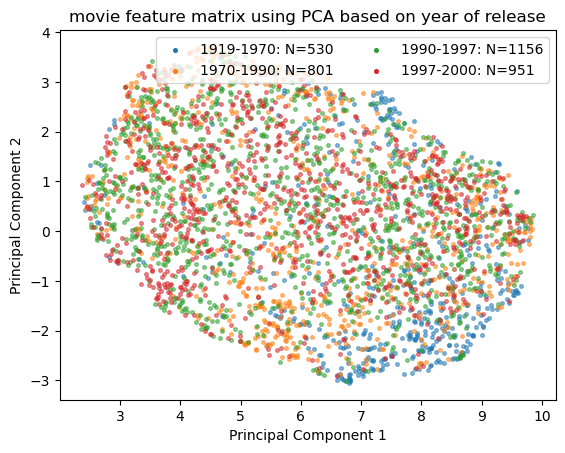

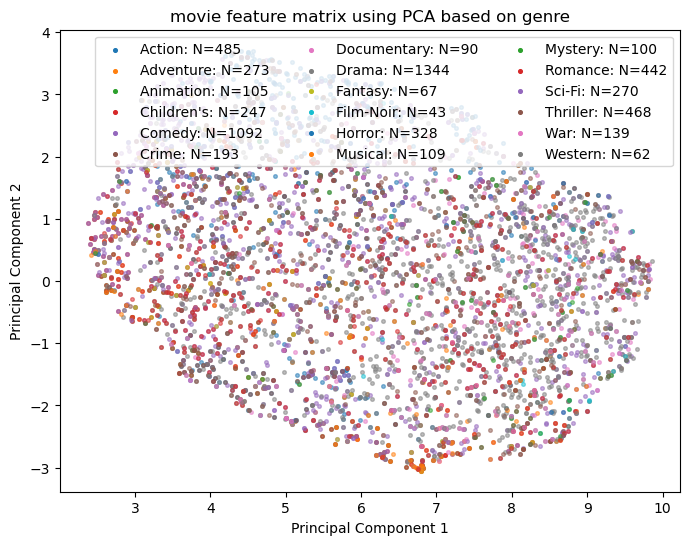

In [51]:
#Obtain the movie attributes
movies1_df = moviesData[moviesData['MovieID'].isin(movies1)]

#Define the years the movies were released and corresponding labels
years = movies1_df['Title'].str.extract('\((\d{4})\)',expand=False).astype(int)
labels_year = ['1919-1970','1970-1990','1990-1997','1997-2000']
ranges_year = [1919,1970,1990,1997,2000]

#Define the genres of the movies and corresponding labels
movies1_genre = movies1_df['Genres']
labels_genre = ['Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama',\
               'Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

#Apply the PCA on the U-matrix, reducing the number of user-features and thus the amount of columns to 2

umap_V1 = umap.UMAP(n_components=2)
umap_fit_V1 = umap_V1.fit_transform(V1)
#pca = PCA(n_components=2)
#pca_data = pca.fit_transform(V1)

#Visualise the clustering based on year of release 
fig, ax = plt.subplots()
for i in range(len(labels_year)):
    #Obtain the indices corresponding to various release year ranges
    if i != len(labels_year)-1:
        indices = np.where( (ranges_year[i+1] > years) & (years >= ranges_year[i]) ) #get all indices between 2 years
    else:
        indices = np.where( (years >= ranges_year[i]) ) #get all indices of the most recently released movies
        
    num_movies = len(indices[0]) #obtain the number of movies 
    labels_year[i] = str(labels_year[i])+': N='+str(num_movies) #add number of movies to the labels
    ax.scatter(umap_fit_V1[:,0][indices], umap_fit_V1[:,1][indices], s=7,alpha=0.5,label=labels_year[i])
    
leg = ax.legend(ncol=2)
for lh in leg.legend_handles: 
    lh.set_alpha(1)
ax.set_title('movie feature matrix using PCA based on year of release')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
#ax.set_xlim([-2,2.2])
#ax.set_ylim([-0.7,1])
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
for i in range(len(labels_genre)):
    #Obtain the indices corresponding to various movie ranges
    genre_indices = np.char.find(list(movies1_genre),labels_genre[i])
    indices = np.where(genre_indices != -1)
        
    num_movies = len(indices[0]) #obtain the number of movies 
    labels_genre[i] = str(labels_genre[i])+': N='+str(num_movies) #add number of movies to the labels
    ax.scatter(umap_fit_V1[:,0][indices], umap_fit_V1[:,1][indices], s=7,alpha=0.5,label=labels_genre[i])
    
leg = ax.legend(ncol=3)
for lh in leg.legend_handles: 
    lh.set_alpha(1)
ax.set_title('movie feature matrix using PCA based on genre')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
#ax.set_xlim([-2,2.2])
#ax.set_ylim([-0.7,1])
plt.show()

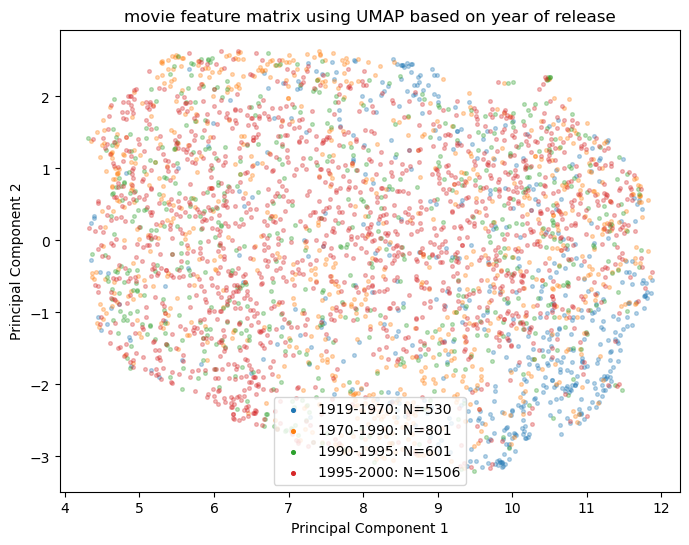

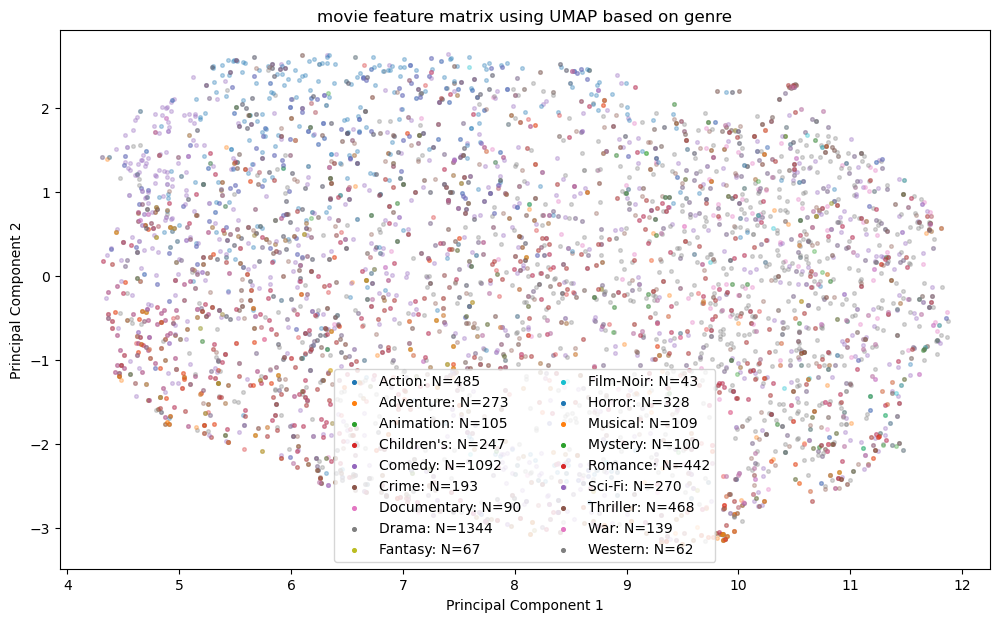

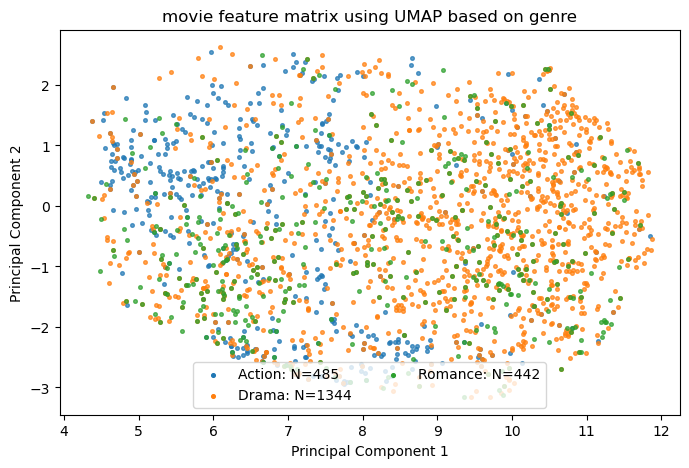

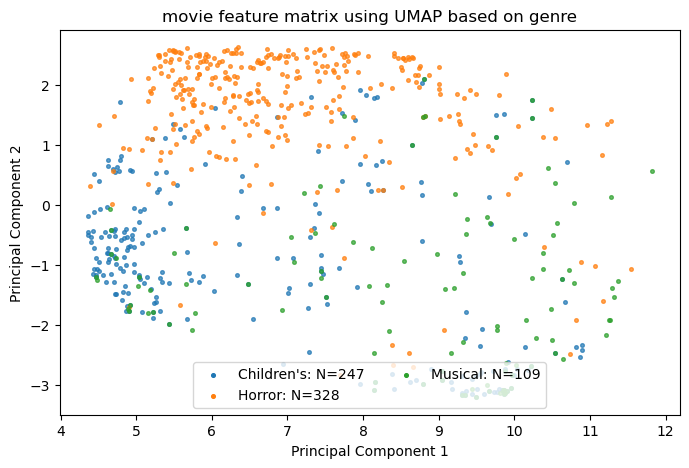

In [52]:
umap_M1 = umap.UMAP(n_components=2)
umap_fit_M1 = umap_M1.fit_transform((V1))

#Define the years the movies were released and corresponding labels
years = movies1_df['Title'].str.extract('\((\d{4})\)',expand=False).astype(int)
labels_year = ['1919-1970','1970-1990','1990-1995','1995-2000']
ranges_year = [1919,1970,1990,1995,2000]

#Visualise the clustering based on year of release 
fig, ax = plt.subplots(figsize=(8,6))
for i in range(len(labels_year)):
    #Obtain the indices corresponding to various release year ranges
    if i != len(labels_year)-1:
        indices = np.where( (ranges_year[i+1] > years) & (years >= ranges_year[i]) ) #get all indices between 2 years
    else:
        indices = np.where( (years >= ranges_year[i]) ) #get all indices of the most recently released movies
        
    num_movies = len(indices[0]) #obtain the number of movies 
    labels_year[i] = str(labels_year[i])+': N='+str(num_movies) #add number of movies to the labels
    ax.scatter(umap_fit_M1[:,0][indices], umap_fit_M1[:,1][indices], s=7,alpha=0.3,label=labels_year[i])
    
leg = ax.legend(loc='lower center')
for lh in leg.legend_handles: 
    lh.set_alpha(1)
ax.set_title('movie feature matrix using UMAP based on year of release')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
#ax.set_xlim([-2,2.2])
#ax.set_ylim([-0.7,1])
plt.show()

#Define the genres of the movies and corresponding labels
movies1_genre = movies1_df['Genres']
labels_genre = ['Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama',\
               'Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

fig, ax = plt.subplots(figsize=(12,7))
for i in range(len(labels_genre)):
    #Obtain the indices corresponding to various movie ranges
    genre_indices = np.char.find(list(movies1_genre),labels_genre[i])
    indices = np.where(genre_indices != -1)
        
    num_movies = len(indices[0]) #obtain the number of movies 
    labels_genre[i] = str(labels_genre[i])+': N='+str(num_movies) #add number of movies to the labels
    ax.scatter(umap_fit_M1[:,0][indices], umap_fit_M1[:,1][indices], s=7,alpha=0.3,label=labels_genre[i])
    
leg = ax.legend(ncol=2,loc='lower center')
for lh in leg.legend_handles: 
    lh.set_alpha(1)
ax.set_title('movie feature matrix using UMAP based on genre')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
#ax.set_xlim([-2,2.2])
#ax.set_ylim([-0.7,1])
plt.show()

labels_genre = ['Action','Drama','Romance']
fig, ax = plt.subplots(figsize=(8,5))
for i in range(len(labels_genre)):
    #Obtain the indices corresponding to various movie ranges
    genre_indices = np.char.find(list(movies1_genre),labels_genre[i])
    indices = np.where(genre_indices != -1)
        
    num_movies = len(indices[0]) #obtain the number of movies 
    labels_genre[i] = str(labels_genre[i])+': N='+str(num_movies) #add number of movies to the labels
    ax.scatter(umap_fit_M1[:,0][indices], umap_fit_M1[:,1][indices], s=7,alpha=0.7,label=labels_genre[i])
    
leg = ax.legend(ncol=2,loc='lower center')
for lh in leg.legend_handles: 
    lh.set_alpha(1)
ax.set_title('movie feature matrix using UMAP based on genre')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.show()

labels_genre = ["Children's",'Horror','Musical']
fig, ax = plt.subplots(figsize=(8,5))
for i in range(len(labels_genre)):
    #Obtain the indices corresponding to various movie ranges
    genre_indices = np.char.find(list(movies1_genre),labels_genre[i])
    indices = np.where(genre_indices != -1)
        
    num_movies = len(indices[0]) #obtain the number of movies 
    labels_genre[i] = str(labels_genre[i])+': N='+str(num_movies) #add number of movies to the labels
    ax.scatter(umap_fit_M1[:,0][indices], umap_fit_M1[:,1][indices], s=7,alpha=0.7,label=labels_genre[i])
    
leg = ax.legend(ncol=2,loc='lower center')
for lh in leg.legend_handles: 
    lh.set_alpha(1)
ax.set_title('movie feature matrix using UMAP based on genre')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.show()